<a href="https://colab.research.google.com/github/mpedraza98/spotify_recommender/blob/main/code/Cosine_similarity_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we build the recommender system using the cosine similarity score. There are two results, with and without the clustering of the tracks. We didn't use classes in this approach, however the object oriented approach would've saved time and made things easier to understand for outsiders.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# create a list with the features to be used during clustering
col_names = {9:'Danceability', 10:'Energy', 11:'Key', 12:'Loudness', 13: 'Mode', 
             14:'Speechiness', 15:'Acousticness', 16:'Instrumentalness', 17:'Liveness', 18:'Valence', 19:'Tempo'}

cluster_features = np.arange(9,20)            

Reading the dataset, you can modify the path and filename in case you want to re-run this code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/MATH637_Final_Project/data_with_extra_features/

/content/drive/.shortcut-targets-by-id/1_fy5IRsWcSj09qqvWnrAXjoN6kMNYJtN/MATH637_Final_Project/data_with_extra_features


In [ ]:
!ls 

playlist_10k.csv     slice_2_tracks.csv   slice_43_tracks.csv
README.txt	     slice_36_tracks.csv  slice_48_tracks.csv
slice_15_tracks.csv  slice_38_tracks.csv  slice_49_tracks.csv
slice_1_tracks.csv   slice_3_tracks.csv   slice_70_tracks.csv


In [ ]:
df = pd.read_csv('slice_1_tracks.csv', header= None)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,10000,Magic,spotify:track:23khhseCLQqVMCIT1WMAns,Ghost Stories,spotify:album:2G4AUqfwxcV1UdQjm2ouYr,Coldplay,spotify:artist:4gzpq5DPGxSnKTe4SA8HAU,285014,0,0.738,0.482,6,-8.917,0,0.0402,0.02660,0.621000,0.1060,0.352,93.457
1,10000,A Sky Full of Stars,spotify:track:0FDzzruyVECATHXKHFs9eJ,Ghost Stories,spotify:album:2G4AUqfwxcV1UdQjm2ouYr,Coldplay,spotify:artist:4gzpq5DPGxSnKTe4SA8HAU,268466,1,0.545,0.675,6,-6.474,1,0.0279,0.00617,0.001970,0.2090,0.162,124.970
2,10000,Every Little Thing She Does Is Magic,spotify:track:5DnUFzGSrLiiAJRxKoiwFv,Symphonicities,spotify:album:1dpyonY9ev2z5a7rwfERZh,Sting,spotify:artist:0Ty63ceoRnnJKVEYP0VQpk,296826,2,0.432,0.358,2,-9.970,1,0.0309,0.81500,0.010300,0.1920,0.166,81.119
3,10000,I Wanna Be Your Lover - Single Version,spotify:track:4gi2ioQwGOBXTrXlBR9RfQ,The Hits 2,spotify:album:2E5Jr8tcyqKrGzGPmNA3il,Prince,spotify:artist:5a2EaR3hamoenG9rDuVn8j,180080,3,0.793,0.442,8,-11.293,0,0.0564,0.23600,0.001630,0.0662,0.833,115.995
4,10000,Raspberry Beret,spotify:track:5jSz894ljfWE0IcHBSM39i,Around The World In A Day,spotify:album:5FbrTPPlaNSOsChhKUZxcu,Prince,spotify:artist:5a2EaR3hamoenG9rDuVn8j,215173,4,0.761,0.670,2,-12.759,1,0.0438,0.21000,0.000426,0.0685,0.910,120.752


In [ ]:
def clean_up_df(df):
  # clean up the dataset from tracks with problems when retrieving information
  # rows with values of -999 represent tracks whose information couldn't be retrieved
  #
  # Takes the entire dataset as argument and returns a cleaned up copy of it
  
  temp = df.copy()
  temp.sort_values(by=[0], inplace = True)
  temp.drop(temp[temp[9]==-999].index, inplace = True)
  return temp

In [ ]:
def reset_playlist_id(df):
  # the playlists have non ordered ids in the original playlist
  # here we assign a new integer id in a way that it ranges from 0 to the total number of playlists in the dataset
  #
  # Takes the entire dataset as argument and returns a copy with new playlist ids
  
  temp = df.copy()
  playlist_id = temp[0].value_counts()
  playlist_id.sort_index(inplace = True)
  order_id = []

  for i in range(playlist_id.shape[0]):
      order_id = order_id + [i] * playlist_id.iloc[i]

  temp[0] = order_id
  temp.reset_index(inplace = True, drop = True)
  return temp

In [ ]:
def scale_features(df, features):
  # Normalizes the desired columns of a dataset
  # Receives as input a dataframe and a list of columns to be normalized
  # Returns a dataframe with feature columns having mean 0 and std 1
  
  scaler = StandardScaler().fit_transform(df[features])
  temp = df.copy()
  temp[features] = scaler
  return temp

In [ ]:
# drop columns that won't be used in our model
# keep the playlist id, song name, and artist
df_model = df.drop([3,4,6,7,8], axis = 1)

In [ ]:
df_model = clean_up_df(df_model)
df_model = reset_playlist_id(df_model)

In [ ]:
df_model_sc = scale_features(df_model, cluster_features)

In [ ]:
df_model_sc.head()

,0,1,2,5,9,10,11,12,13,14,15,16,17,18,19
0,0,Magic,spotify:track:23khhseCLQqVMCIT1WMAns,Coldplay,0.801805,-0.756420,0.221522,-0.456556,-1.387456,-0.553278,-0.746253,2.948511,-0.540593,-0.583763,-0.973021
1,0,The Sound,spotify:track:316r1KLN0bcmpr7TZcMCXT,The 1975,0.231669,1.402157,-1.436169,0.690683,0.720743,-0.200734,-0.528444,-0.304403,1.694718,0.222535,-0.030993
2,0,Roni,spotify:track:6mdNRnbiVerwM8kGCS1KwD,Bobby Brown,0.671665,0.256597,1.050367,-1.285849,0.720743,-0.582323,-0.800259,-0.304117,-0.911615,1.722332,0.866061
3,0,The Way I Am - The Voice Performance,spotify:track:0Sm6AgYvuyVY4DYxhEHEQU,Caroline Pennell,1.303772,-1.248727,0.497804,0.536237,0.720743,-0.629395,1.815962,-0.304148,-0.553703,0.356222,-0.055641
4,0,You Make It Real,spotify:track:1Yw6ViCo3tuufI0Hg4mzSU,James Morrison,-1.807184,-0.339852,-1.436169,0.527184,0.720743,-0.631398,0.024128,-0.304437,-0.284941,-0.709094,-1.291190


In [ ]:
def get_unique_tracks(df):
  # Get Unique sound tracks to compute the similarity measurement
  # Receives a dataframe 
  # Returns a dataframe with unique tracks
  
  temp = df_model_sc.drop_duplicates(2)
  temp.drop(0, axis = 1, inplace = True)
  temp.set_index(2, inplace=True)
  return temp

In [ ]:
unique_tracks = get_unique_tracks(df_model_sc)

<ipython-input-12-6fedb51a1e15>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.drop(0, axis = 1, inplace = True)


In [ ]:
unique_tracks.head()

,1,5,9,10,11,12,13,14,15,16,17,18,19
2,,,,,,,,,,,,,
spotify:track:23khhseCLQqVMCIT1WMAns,Magic,Coldplay,0.801805,-0.756420,0.221522,-0.456556,-1.387456,-0.553278,-0.746253,2.948511,-0.540593,-0.583763,-0.973021
spotify:track:316r1KLN0bcmpr7TZcMCXT,The Sound,The 1975,0.231669,1.402157,-1.436169,0.690683,0.720743,-0.200734,-0.528444,-0.304403,1.694718,0.222535,-0.030993
spotify:track:6mdNRnbiVerwM8kGCS1KwD,Roni,Bobby Brown,0.671665,0.256597,1.050367,-1.285849,0.720743,-0.582323,-0.800259,-0.304117,-0.911615,1.722332,0.866061
spotify:track:0Sm6AgYvuyVY4DYxhEHEQU,The Way I Am - The Voice Performance,Caroline Pennell,1.303772,-1.248727,0.497804,0.536237,0.720743,-0.629395,1.815962,-0.304148,-0.553703,0.356222,-0.055641
spotify:track:1Yw6ViCo3tuufI0Hg4mzSU,You Make It Real,James Morrison,-1.807184,-0.339852,-1.436169,0.527184,0.720743,-0.631398,0.024128,-0.304437,-0.284941,-0.709094,-1.291190


In [ ]:
#List of playlists in the dataset
playlists = df_model_sc[0].unique()

To visualize the distribution of the number of songs per playlist we build a violin plot

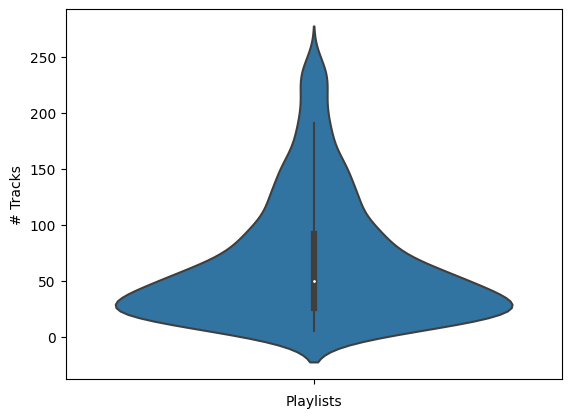

In [ ]:
ax = sns.violinplot(y=df_model_sc[0].value_counts())
ax.set(ylabel='# Tracks', xlabel='Playlists');

In this section we will define all the functions used to calculate the cosine similarity score and make the radar plots displaying examples of tracks within playlists

In [ ]:
def split_data(df):
  # split the dataset into a 75-25 content
  # Takes a dataframe as input and returns two dataframes s

    X_train, X_test = train_test_split(df, test_size=0.25, random_state=42)
    return X_train, X_test
    

In [ ]:
def get_playlist_vec(df, features):
    # Calculates the representative vector of a playlist
    # This vector is the average of each feature for a set of tracks within the playlist
    # Column 0 contains the playlist id for that specific track 
    #
    playlist_values = df[features].values
    playlist_vec = playlist_values.mean(axis = 0)
    return playlist_vec

In [ ]:
def get_cosine_similarity(tracks_df, playlist_train, n_tracks, features):
    # The dataframe as input is the training dataframe obtained from the split
    # gets the playlist vector as the average over tracks for the features
    playlist_vec = get_playlist_vec(playlist_train, features)
    

    tracks= tracks_df.drop(playlist_train[2].values)
#    tracks.reset_index(drop=True, inplace=True)
    tracks_values = tracks[features].values
    rank = cosine_similarity(tracks_values, playlist_vec.reshape(-1, 1).T)
    rank_ids = np.argsort(rank.T)
    
    #get the songs info to be returned
    tracks = tracks.iloc[rank_ids.ravel()[:n_tracks]]
    recommended_tracks = tracks[1] +", "+ tracks[5]
    # Returns the similarity score
    return rank[:n_tracks], recommended_tracks
    
    

In [ ]:
def get_euclidean_similarity(tracks_df, playlist_train, n_tracks, features):
    # The dataframe as input is the training dataframe obtained from the split
    # gets the playlist vector as the average over tracks for the features
    playlist_vec = get_playlist_vec(playlist_train, features)
    

    tracks= tracks_df.drop(playlist_train[2].values)
#    tracks.reset_index(drop=True, inplace=True)
    tracks_values = tracks[features].values
    rank = euclidean_distances(tracks_values, playlist_vec.reshape(-1, 1).T)
    rank_ids = np.argsort(rank.T)
    
    #get the songs info to be returned
    tracks = tracks.iloc[rank_ids.ravel()[::-1][:n_tracks]]
    recommended_tracks = tracks[1] +", "+ tracks[5]
    # Returns the similarity score
    return rank[:n_tracks], recommended_tracks


In [ ]:
def get_r_score(playlist_id, df, features, tracks):
    # Receive the playlist_id, dataframe, features and list of unique tracks as inputs
    # Returns the r score and a list of recommended tracks for the playlist
    playlist_train, playlist_test = split_data(df[df[0]==playlist_id])
    #Size of the test set
    N = playlist_test.shape[0]
    score, recommended_tracks = get_cosine_similarity(tracks, playlist_train, 15*N, features)
#    print(recommended_tracks.shape, playlist_test.shape)
    matches = np.intersect1d(recommended_tracks.index.values, playlist_test[2].values)
#    print(matches)
    r_score = matches.shape[0]/playlist_test.shape[0]
    return r_score, recommended_tracks
        

In [ ]:
# radar plot for a playlist
# https://www.python-graph-gallery.com/390-basic-radar-chart
def radar_playlist(values, categories, ax, label = ''):
  # Set data

  # number of variable
  N = len(categories)
  
  # We are going to plot the first line of the data frame.
  # But we need to repeat the first value to close the circular graph:
  values=values.tolist()
  values += values[:1]
  values
  
  # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
  angles = [n / float(N) * 2 * np.pi for n in range(N)]
  angles += angles[:1]
  
  # Initialise the spider plot
  #ax = plt.subplot(111, polar=True)
  
  # Draw one axe per variable + add labels
  plt.xticks(angles[:-1], categories, color='grey', size=7)
  
  # Draw ylabels
  ax.set_rlabel_position(0)

  min_value = np.min(values)
  max_value = np.max(values)
  y_tick = np.linspace(min_value, max_value, 10)
  #plt.yticks([-0.2,-0.4,-0.6,-0.8,0.2,0.4,0.6,0.8,0], ["-0.2","-0.4","-0.6","-0.8","0.2","0.4","0.6","0.8","0"], color="grey", size=8)
  plt.yticks(color="grey", size=8)
  plt.ylim(min_value,max_value)
  
  # Plot data
  ax.plot(angles, values, linewidth=1, linestyle='solid', label = label)
  
  # Fill area
  ax.fill(angles, values, alpha=0.1)

  # Show the graph
  return ax

In [ ]:
def get_recommended_vector(playlist_id, rec_track, tracks):
  ids = rec_track[playlist_id].index
  temp_tracks = tracks.loc[ids][cluster_features]
  mean_vector = temp_tracks.mean().values
  return mean_vector


We calculate the r score using cosine similarity and euclidean distance

In [ ]:
# scores using euclidean distance
scores_euclidean = []
recommended_euclidean = []
playlists_df = df_model_sc[0].unique()
for i in playlists_df:
  temp = get_r_score(i,df_model_sc, cluster_features, unique_tracks)
  scores_euclidean.append(temp[0])
  recommended_euclidean.append(temp[1])

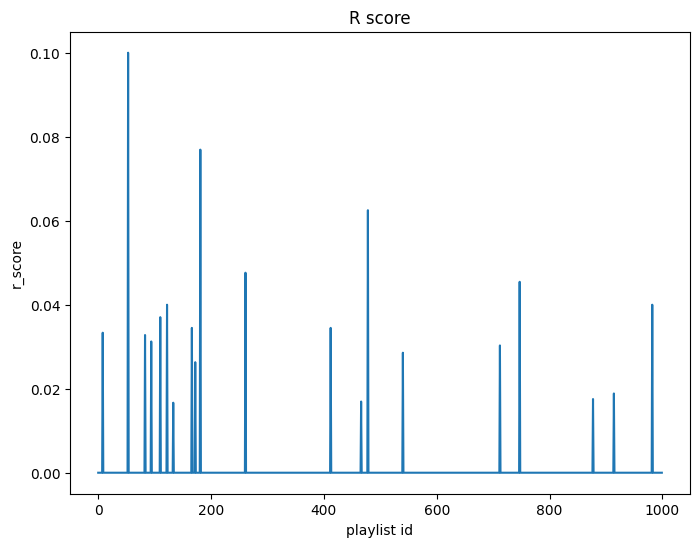

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(playlists_df,scores_euclidean)
plt.xlabel('playlist id');
plt.ylabel('r_score');
plt.title('R score');

In [ ]:
# scores using cosine similarity
scores = []
recommended = []
playlists_df = df_model_sc[0].unique()
for i in playlists_df:
  temp = get_r_score(i,df_model_sc, cluster_features, unique_tracks)
  scores.append(temp[0])
  recommended.append(temp[1])

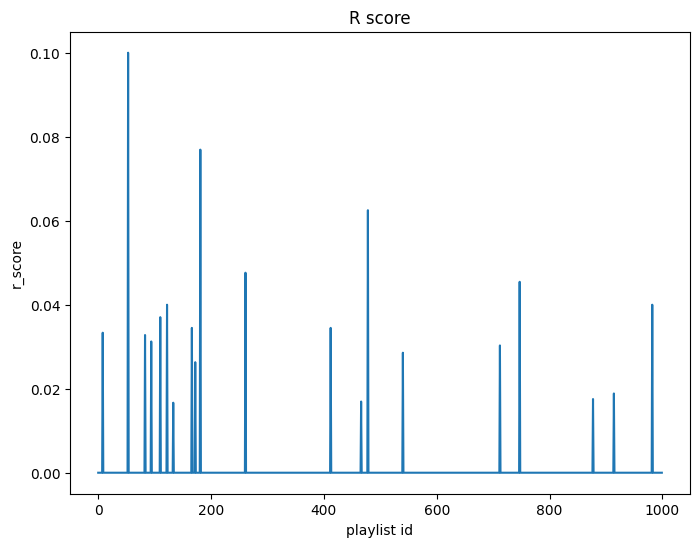

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(playlists_df,scores)
plt.xlabel('playlist id');
plt.ylabel('r_score');
plt.title('R score');

In [ ]:
np.array(scores).mean()*100

0.07710872945889287

In [ ]:
# the highest score is for the playlist 53
np.argmax(scores)

53

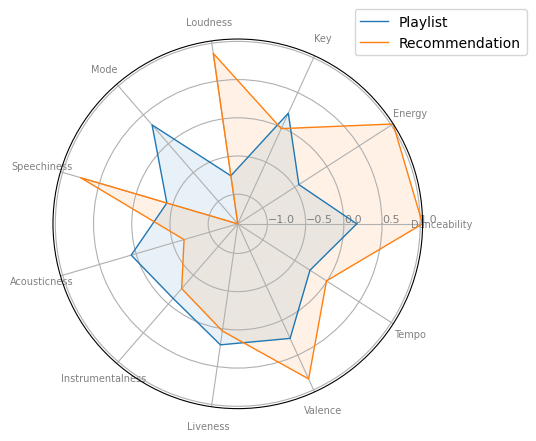

In [ ]:
# plot the highest score playlist to visualize features from the predicted tracks agains the original tracks
# we used cosine similarity only for this plot, as the results were the same for euclidean distance

pred_playlist_1 = get_recommended_vector(50, recommended, unique_tracks)
ax = plt.subplot(111, polar=True);
radar_playlist(df_model_sc[df_model_sc[0]==0][np.arange(9,20)].mean(), col_names.values(), ax , 'Playlist')
radar_playlist(pred_playlist_1, col_names.values(), ax, 'Recommendation')
plt.legend(bbox_to_anchor = [1.3, 1.1]);

We will repeat the cosine similarity calculation after clustering our features, the clustering analysis was done in the clustering notebook

In [ ]:
# dataframe features to be clustered
new_features = np.arange(9,21)

In [ ]:
# clustering our data using sklearn kmeans
#Create a function to append the cluste label as a feature
km_recommender = KMeans(n_clusters=6, max_iter=100, random_state=1234)
km_recommender.fit(df_model_sc[cluster_features])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=100, n_clusters=6, random_state=1234)

In [ ]:
# We add the labels for each track as an extra column in the dataset
df_model_sc[20] = km_recommender.labels_
df_model_sc = scale_features(df_model_sc, new_features)

In [ ]:
# get unique tracks again, with the cluster label
unique_tracks_label = get_unique_tracks(df_model_sc)

<ipython-input-15-6fedb51a1e15>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.drop(0, axis = 1, inplace = True)


In [ ]:
# calculate the r score for the data
scores_label = []
recommended_label = []
playlists_df = df_model_sc[0].unique()
for i in playlists_df:
  temp = get_r_score(i,df_model_sc, new_features, unique_tracks_label)
  scores_label.append(temp[0])
  recommended_label.append(temp[1])

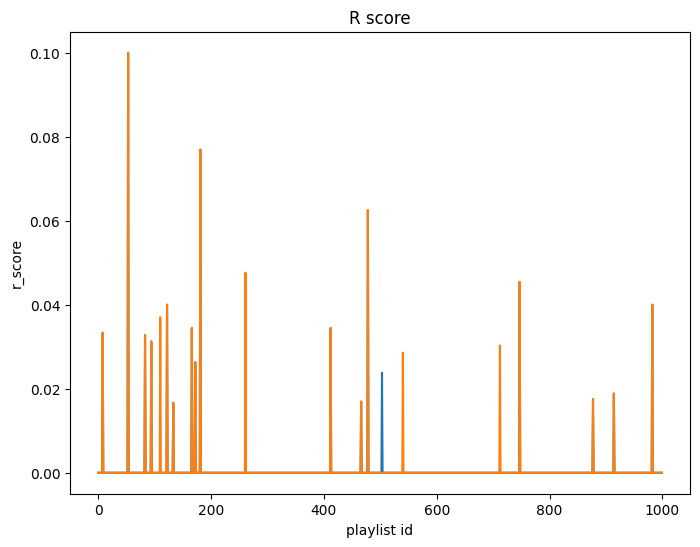

In [ ]:
# We plot the r scroe with and without clustering to fin any differences

plt.figure(figsize=(8,6))
plt.plot(playlists_df,scores_label)
plt.xlabel('playlist id');
plt.ylabel('r_score');
plt.title('R score');

#plt.figure(figsize=(8,6))
plt.plot(playlists_df,scores)
plt.xlabel('playlist id');
plt.ylabel('r_score');
plt.title('R score');

Now, we will make some radar plots to visualize the original and predicted features of the playlists

In [ ]:
np.array(scores_label).mean()*100

0.0651366274867909

In [ ]:
pred_playlist0 = get_recommended_vector(0, recommended_label, unique_tracks_label)

<PolarAxes: >

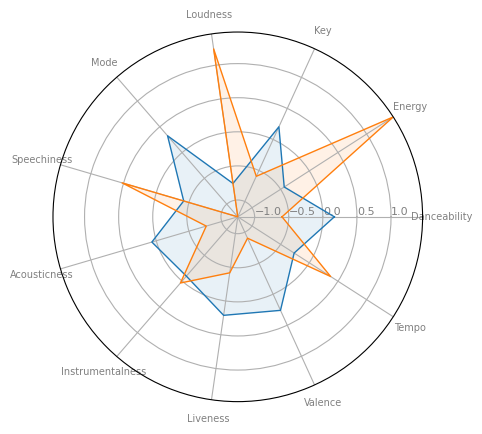

In [ ]:
ax = plt.subplot(111, polar=True);
radar_playlist(df_model_sc[df_model_sc[0]==0][np.arange(9,20)].mean(), col_names.values(), ax)
radar_playlist(pred_playlist0, col_names.values(), ax)

In [ ]:
# the highest score is for the playlist 53
np.argmax(scores_label)

53

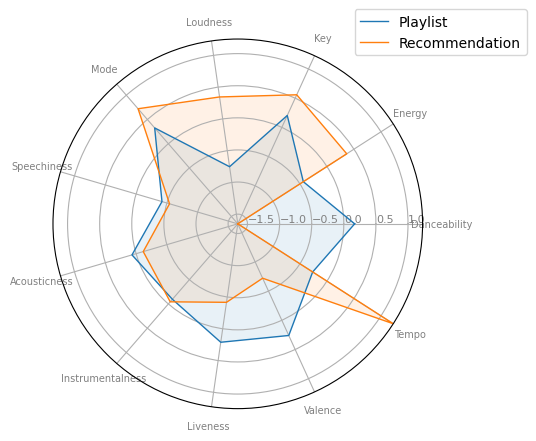

In [ ]:
pred_playlist53 = get_recommended_vector(53, recommended_label, unique_tracks_label)
ax = plt.subplot(111, polar=True);
radar_playlist(df_model_sc[df_model_sc[0]==0][np.arange(9,20)].mean(), col_names.values(), ax , 'Playlist')
radar_playlist(pred_playlist53, col_names.values(), ax, 'Recommendation')
plt.legend(bbox_to_anchor = [1.3, 1.1]);